In [5]:
using Distributions
using Plots
using Random
using Statistics
using QuadGK

In [36]:
dist = Distributions.Normal(0, 1/12)
f(x) = x * pdf(dist, x)
veh_cost = 600
op_cost = 160
delay_cost = 37
ridership = 1:100
buffers = 0.3:0.3:15;

# Delay grows with $n$

In [50]:
function get_delay(delays)
    n = size(delays, 1)
    m = size(delays, 2)
    prop_delays = zeros(Float64, n, m)
    prop_delays[1, :] .= max.(delays[1, :], 0) # first trip delay

    for i in 1:n-1
        prop_delays[i+1, :] .= max.(prop_delays[i, :] .+ delays[i+1, :], 0)
    end

    return prop_delays
end

get_delay (generic function with 1 method)

In [53]:
cost_lo

100-element Vector{Any}:
    0.0
    0.0
    0.0
    3.296825953704823
    0.0
    6.5314483524787805
   14.830769736554883
    3.9536712330375146
   17.50374563178356
   30.316072722904924
   24.169504425369713
   42.082402566901045
   34.38440737693701
    ⋮
 2068.7601730058623
 2218.5118970565195
 2740.3663327071213
 2363.9693442207868
 2302.7562269938185
 2413.6736081894287
 2682.245178042995
 2046.787482823529
 1787.155147793096
 3184.981638917809
 3123.193411941504
 2978.6833048429444

In [59]:
num_scenarios = 100
r = 30
cost = []
cost_lo = []
cost_hi = []

for i in 1:20
    delays = rand(dist, i, num_scenarios)
    prop_delays = get_delay(delays)
    push!(cost, sum(mean(prop_delays, dims=2)*r*delay_cost))
    push!(cost_lo, sum(quantile.(eachrow(prop_delays), 0.25)*r*delay_cost))
    push!(cost_hi, sum(quantile.(eachrow(prop_delays), 0.75)*r*delay_cost))
end

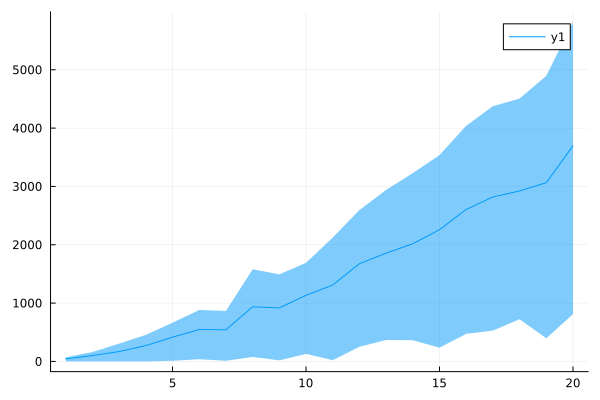

In [61]:
plot(
    1:20,
    cost,
    ribbon=(abs.(cost_lo.-cost), abs.(cost_hi.-cost))
)

# RTA vs. delay-aware

In [87]:
rta = zeros(Float64, 100, 50)

for i in 1:100
    d = quantile(dist, max(1 - op_cost / delay_cost / ridership[i], 1e-4))
    d = max(d, 0)
    for j in 1:50
        integral, error = quadgk(f, buffers[j], Inf)
        flag = d > buffers[j]
        v = (flag+1) * veh_cost
        o = max(buffers[j], d) / 60 * op_cost
        p = (!flag) * delay_cost * ridership[i] * integral / 60
        rta[i, j] = v + o + p
    end
end

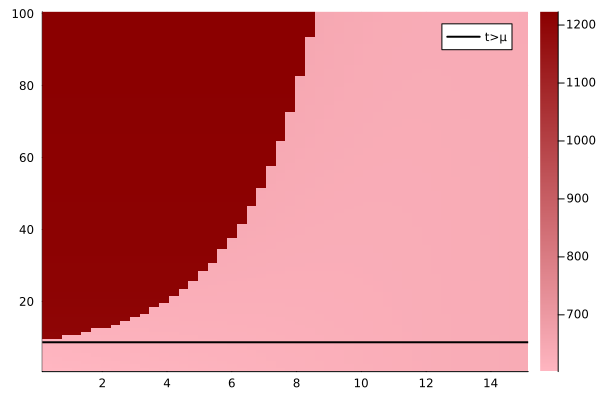

In [98]:
heatmap(
    buffers,
    ridership,
    rta,
    color=:reds,
)
hline!(
    [8.65],
    lw=2,
    color=:black,
    label="t>μ"
)

In [91]:
delay_aware = zeros(Float64, 100, 50)

for i in 1:50
    integral, error = quadgk(f, buffers[i], Inf)
    for j in 1:100
        flag = (veh_cost - delay_cost * ridership[j] * integral / 60) / op_cost < buffers[i] / 60
        v = (flag+1) * veh_cost
        o = (!flag) * buffers[i] * op_cost / 60
        p = (!flag) * delay_cost * ridership[j] * integral / 60
        delay_aware[j, i] = v + o + p
    end
end

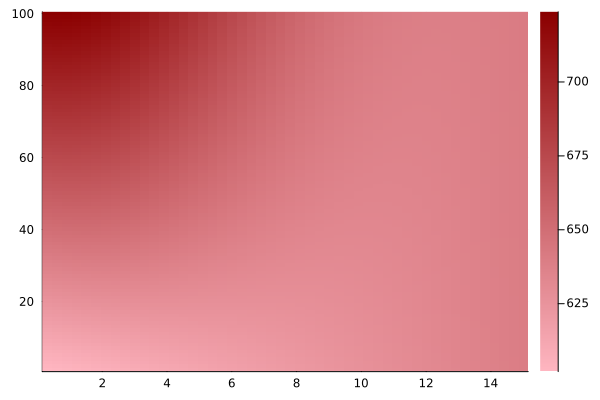

In [92]:
heatmap(
    buffers,
    ridership,
    delay_aware,
    color=:reds,
)

In [93]:
hmap = rta - delay_aware;

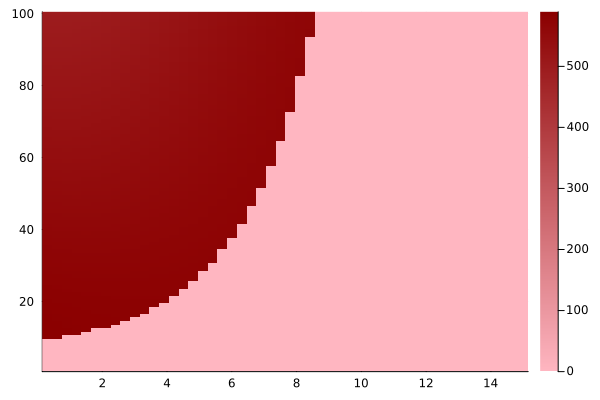

In [94]:
heatmap(
    buffers,
    ridership,
    hmap,
    color=:reds,
)